<a href="https://colab.research.google.com/github/Codedestructor56/Pneumonia-detection/blob/main/PneumoniaDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.feature_selection import SelectKBest, f_classif
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import cv2
import os

Dataset to be used: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
base_dir = '/content/drive/MyDrive/xray_ims'
normal_dir = os.path.join(base_dir, 'NORMAL')
pneumonia_dir = os.path.join(base_dir, 'PNEUMONIA')

<h1> EXPLORATORY DATA ANALYSIS </h1>

In [5]:
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
pneumonia_images = [os.path.join(pneumonia_dir, img) for img in os.listdir(pneumonia_dir)]

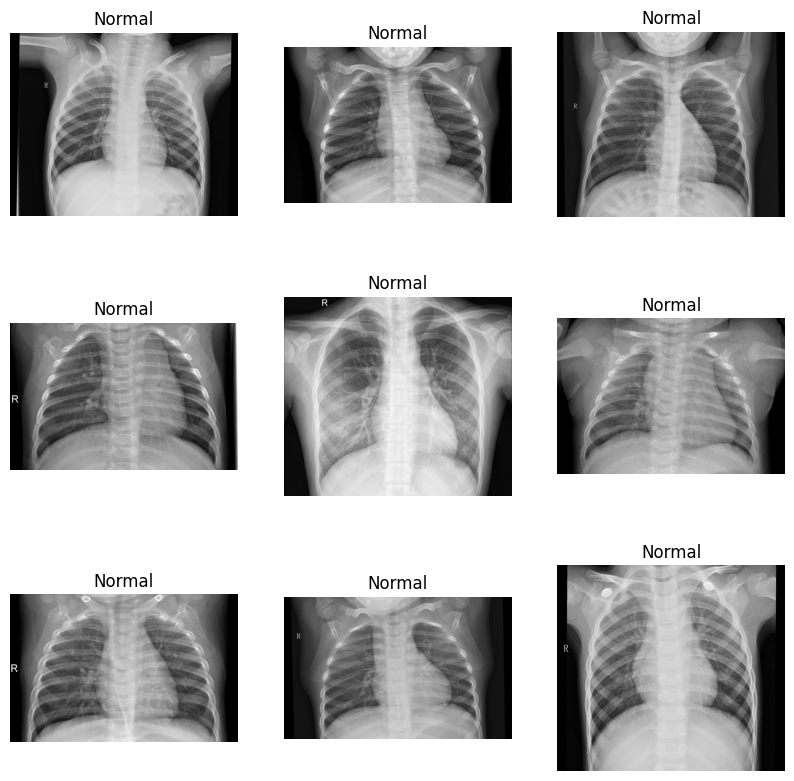

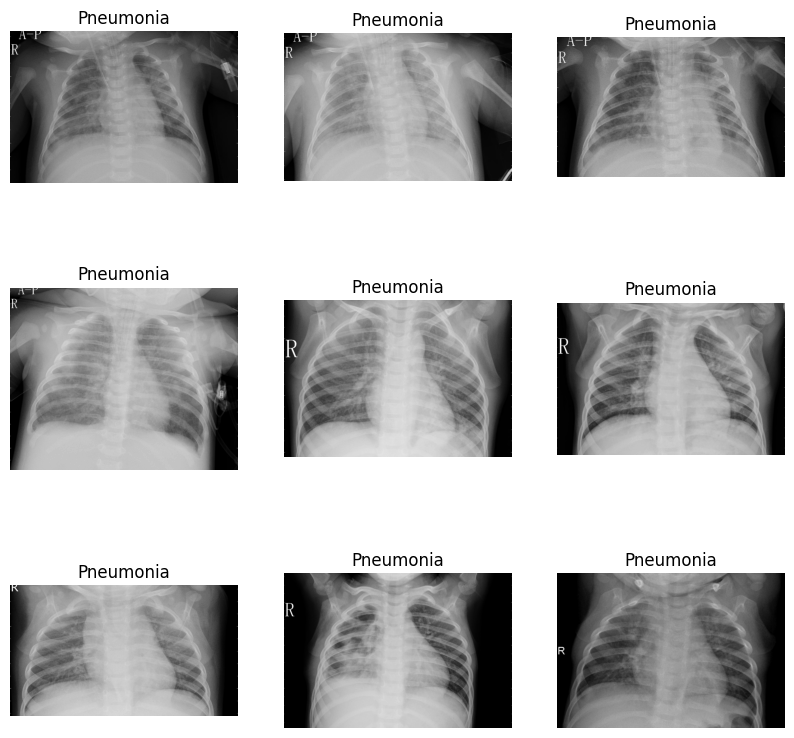

In [6]:


# Display the first few images from each class
def display_sample_images(image_paths, title):
    plt.figure(figsize=(10, 10))
    for i, image_path in enumerate(image_paths[:9]):
        plt.subplot(3, 3, i + 1)
        img = Image.open(image_path)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

display_sample_images(normal_images, "Normal")
display_sample_images(pneumonia_images, "Pneumonia")


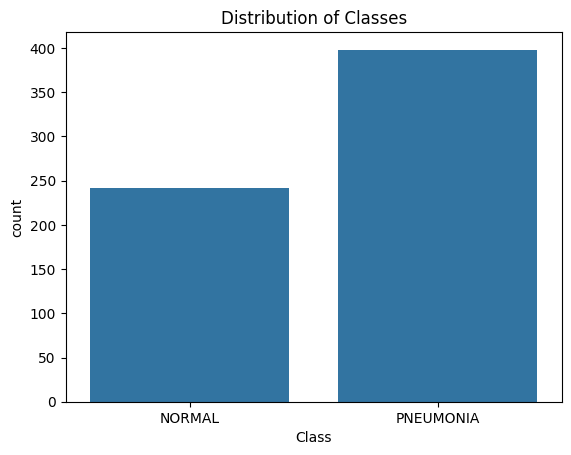

In [7]:
num_normal = len(os.listdir(normal_dir))
num_pneumonia = len(os.listdir(pneumonia_dir))

data = pd.DataFrame({
    'Class': ['NORMAL'] * num_normal + ['PNEUMONIA'] * num_pneumonia,
    'Count': [num_normal] * num_normal + [num_pneumonia] * num_pneumonia
})

sns.countplot(x='Class', data=data)
plt.title('Distribution of Classes')
plt.show()


In [8]:
def get_image_stats(image_paths):
    dimensions = []
    mean_values = []
    for image_path in image_paths:
        img = Image.open(image_path).convert('L')
        img_array = np.array(img)
        dimensions.append(img_array.shape)
        mean_values.append(np.mean(img_array))
    return dimensions, mean_values

normal_dimensions, normal_means = get_image_stats(normal_images)
pneumonia_dimensions, pneumonia_means = get_image_stats(pneumonia_images)

stats_df = pd.DataFrame({
    'Class': ['NORMAL'] * num_normal + ['PNEUMONIA'] * num_pneumonia,
    'Dimensions': normal_dimensions + pneumonia_dimensions,
    'Mean Pixel Value': normal_means + pneumonia_means
})

# Display summary statistics of the images
print(stats_df.groupby('Class').describe())


          Mean Pixel Value                                                \
                     count        mean        std        min         25%   
Class                                                                      
NORMAL               242.0  124.063466  16.368928  80.067306  112.124636   
PNEUMONIA            398.0  119.364193  17.297474  58.722966  108.933176   

                                               
                  50%         75%         max  
Class                                          
NORMAL     124.381533  136.192881  160.891849  
PNEUMONIA  119.800268  131.533424  159.438594  


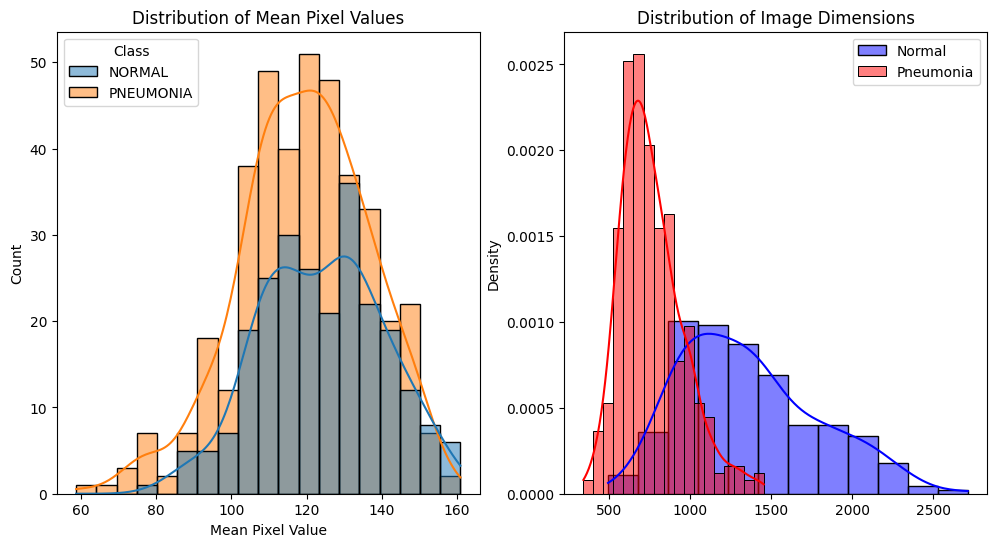

In [9]:
# Visualize mean pixel value distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=stats_df, x='Mean Pixel Value', hue='Class', kde=True)
plt.title('Distribution of Mean Pixel Values')

# Visualize image dimensions
normal_dims = [dim[0] for dim in normal_dimensions]
pneumonia_dims = [dim[0] for dim in pneumonia_dimensions]

plt.subplot(1, 2, 2)
sns.histplot(normal_dims, color='blue', label='Normal', kde=True, stat="density")
sns.histplot(pneumonia_dims, color='red', label='Pneumonia', kde=True, stat="density")
plt.title('Distribution of Image Dimensions')
plt.legend()

plt.show()


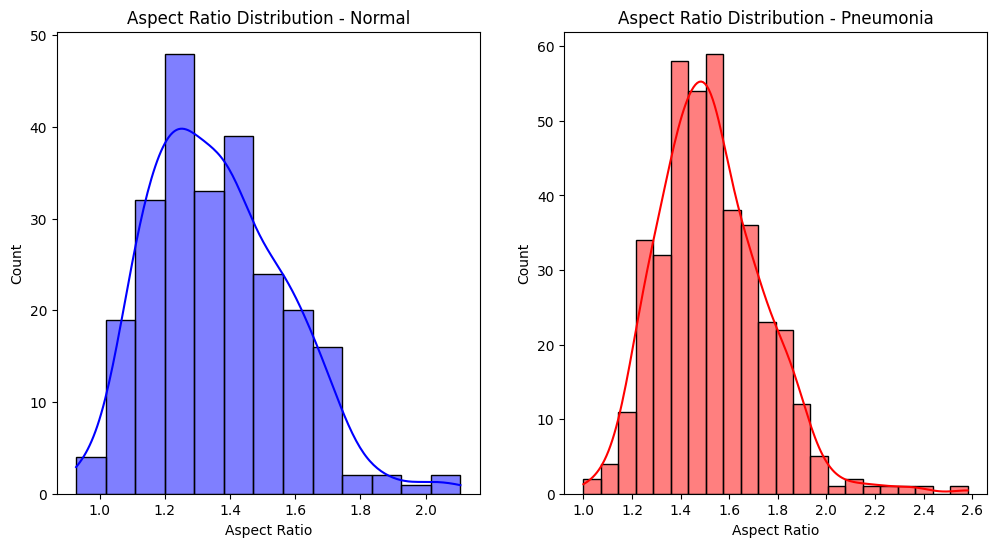

In [10]:
def get_aspect_ratios(dimensions):
    aspect_ratios = [dim[1] / dim[0] for dim in dimensions]  # width / height
    return aspect_ratios

# Get aspect ratios for both classes
normal_aspect_ratios = get_aspect_ratios(normal_dimensions)
pneumonia_aspect_ratios = get_aspect_ratios(pneumonia_dimensions)

# Plot aspect ratio distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(normal_aspect_ratios, kde=True, color='blue', label='Normal')
plt.title('Aspect Ratio Distribution - Normal')
plt.xlabel('Aspect Ratio')

plt.subplot(1, 2, 2)
sns.histplot(pneumonia_aspect_ratios, kde=True, color='red', label='Pneumonia')
plt.title('Aspect Ratio Distribution - Pneumonia')
plt.xlabel('Aspect Ratio')

plt.show()


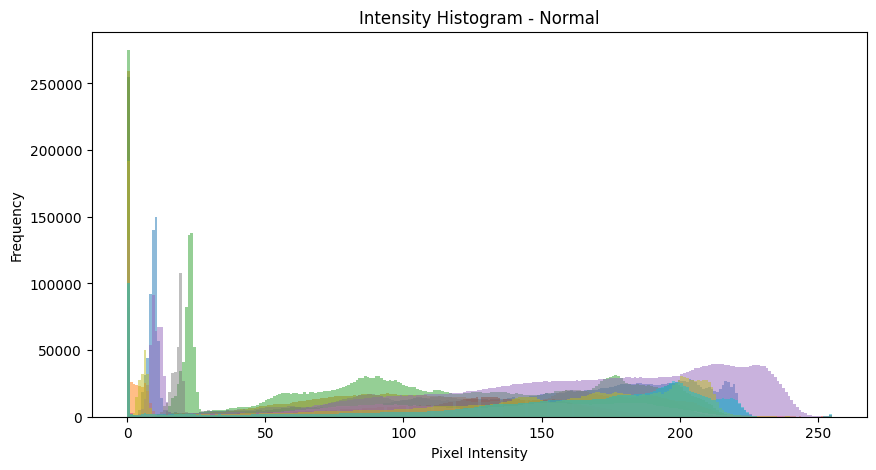

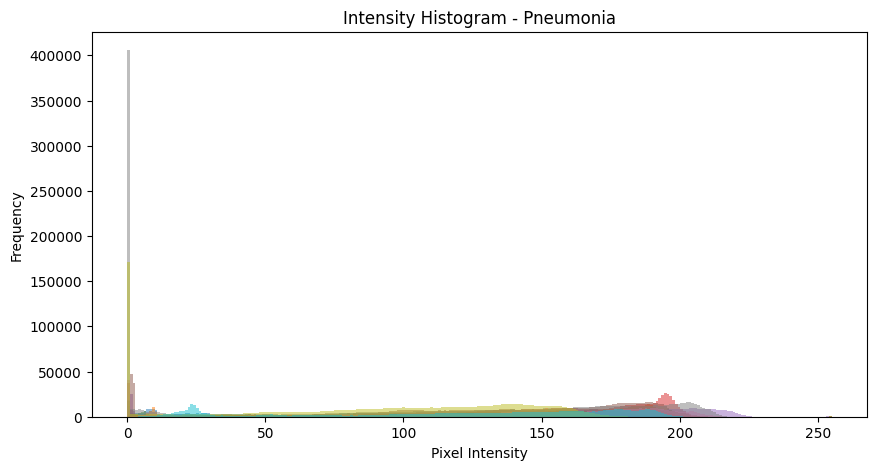

In [11]:
#Just plotting out the brightness of the pixels(intensity)
#So this metric will tell us how many pixels in a particular image have a particular intensity
def plot_intensity_histogram(image_paths, title):
    plt.figure(figsize=(10, 5))
    for image_path in image_paths[:10]:
        img = Image.open(image_path).convert('L')
        img_array = np.array(img)
        plt.hist(img_array.ravel(), bins=256, alpha=0.5)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_intensity_histogram(normal_images, 'Intensity Histogram - Normal')
plot_intensity_histogram(pneumonia_images, 'Intensity Histogram - Pneumonia')


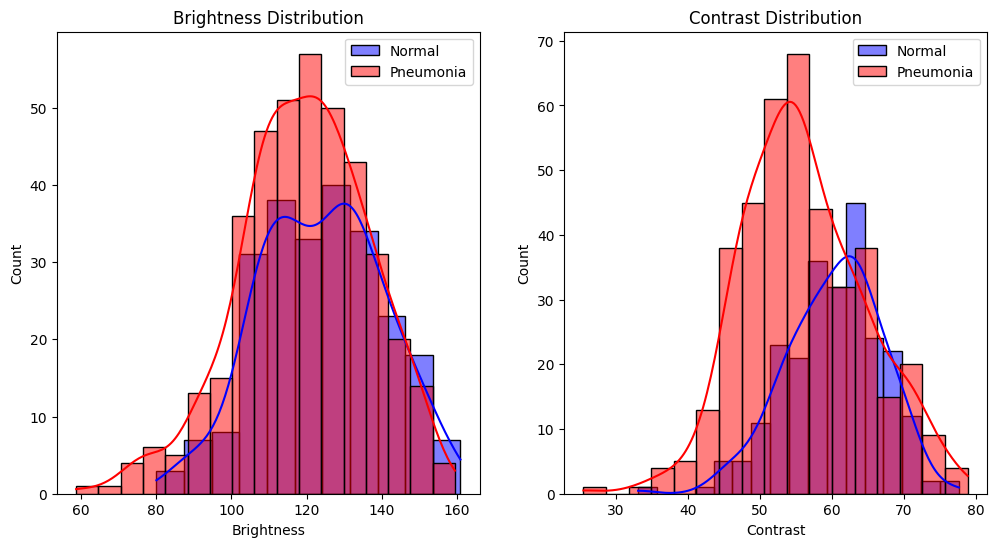

In [12]:
#mean(img) = brightness
#std(img) = contrast
def calculate_brightness_contrast(image_paths):
    brightness = []
    contrast = []
    for image_path in image_paths:
        img = Image.open(image_path).convert('L')
        img_array = np.array(img)
        brightness.append(np.mean(img_array))
        contrast.append(np.std(img_array))
    return brightness, contrast

# Get brightness and contrast for both classes
normal_brightness, normal_contrast = calculate_brightness_contrast(normal_images)
pneumonia_brightness, pneumonia_contrast = calculate_brightness_contrast(pneumonia_images)

# Plot brightness and contrast distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(normal_brightness, kde=True, color='blue', label='Normal')
sns.histplot(pneumonia_brightness, kde=True, color='red', label='Pneumonia')
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(normal_contrast, kde=True, color='blue', label='Normal')
sns.histplot(pneumonia_contrast, kde=True, color='red', label='Pneumonia')
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.legend()

plt.show()


In [13]:
from sklearn.model_selection import train_test_split
image_paths = normal_images+pneumonia_images
labels = [0]*len(normal_images) + [1]*len(pneumonia_images)

<h1>Data preprocessing: </h1>

In [14]:
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        image = imread(path)
        if len(image.shape) == 3:
            #Just reducing the channels here because that information is useless for X-rays
            image = rgb2gray(image)
        image = resize(image, (64, 64))
        images.append(image.flatten())
    return np.array(images)


X = preprocess_images(image_paths)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h1> Feature Engineering: </h1>

In [15]:
#Selecting the 500 most relevant features
selector = SelectKBest(f_classif, k=500)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [16]:
#applying standard scaling to the images
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_selected)
X_test_normalized = scaler.transform(X_test_selected)

<h1>KNN in sklearn: </h1>

Accuracy with sklearn KNN: 80.47%


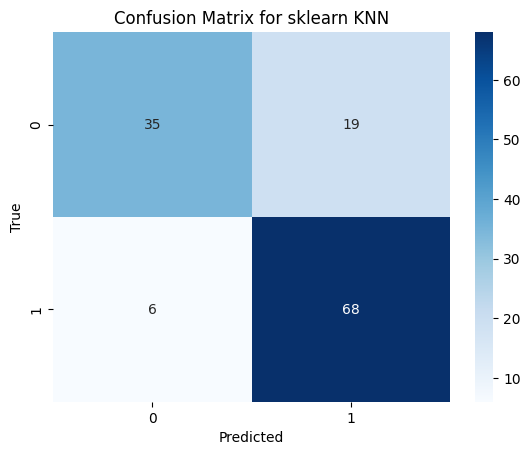

In [18]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_normalized, y_train)
y_pred = knn.predict(X_test_normalized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with sklearn KNN: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for sklearn KNN')
plt.show()

<h1> KNN from scratch: </h1>

In [19]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def knn_predict(X_train, y_train, X_test, k=3):
    y_pred = []
    for test_point in X_test:
        distances = np.array([euclidean_distance(test_point, x) for x in X_train])
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = [y_train[i] for i in k_indices]
        majority_vote = np.bincount(k_nearest_labels).argmax()
        y_pred.append(majority_vote)
    return np.array(y_pred)

In [20]:
y_pred_scratch = knn_predict(X_train_normalized, y_train, X_test_normalized, k=3)
accuracy_scratch = np.sum(y_pred_scratch == y_test) / len(y_test)
print(f'Accuracy with scratch KNN: {accuracy_scratch * 100:.2f}%')

Accuracy with scratch KNN: 80.47%


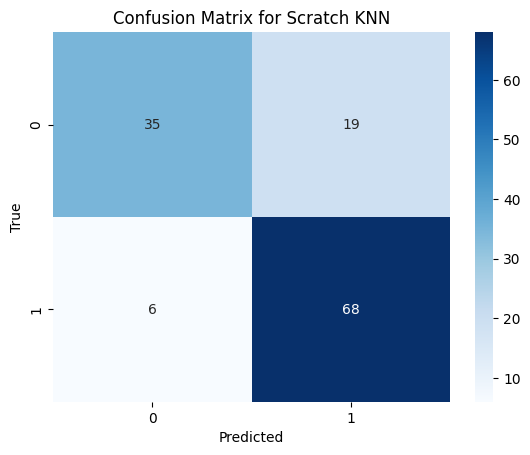

In [21]:
conf_matrix_scratch = confusion_matrix(y_test, y_pred_scratch)

sns.heatmap(conf_matrix_scratch, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Scratch KNN')
plt.show()

<h1> SVC in sklearn: </h1>

Accuracy with sklearn SVM: 85.16%


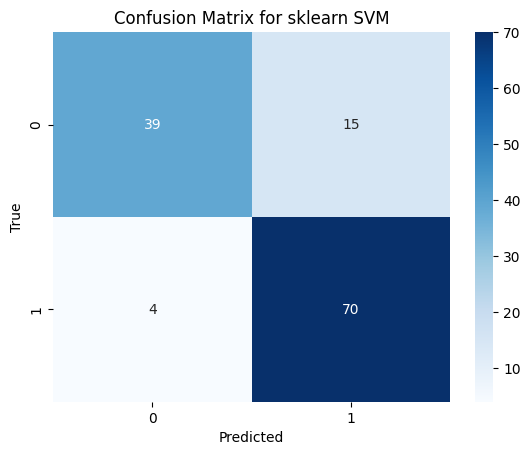

In [22]:
svm = SVC()
svm.fit(X_train_normalized, y_train)
y_pred_svm = svm.predict(X_test_normalized)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy with sklearn SVM: {accuracy_svm * 100:.2f}%')

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for sklearn SVM')
plt.show()

<h1>SVC from scratch:</h1>

In [28]:
class CustomSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        y_ = np.where(y <= 0, -1, 1)
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.where(np.sign(approx) == -1, 0, 1)

custom_svm = CustomSVM()
custom_svm.fit(X_train_normalized, y_train)
y_pred_custom_svm = custom_svm.predict(X_test_normalized)

accuracy_custom_svm = accuracy_score(y_test, y_pred_custom_svm)
print(f'Accuracy with custom SVM: {accuracy_custom_svm * 100:.2f}%')


Accuracy with custom SVM: 83.59%


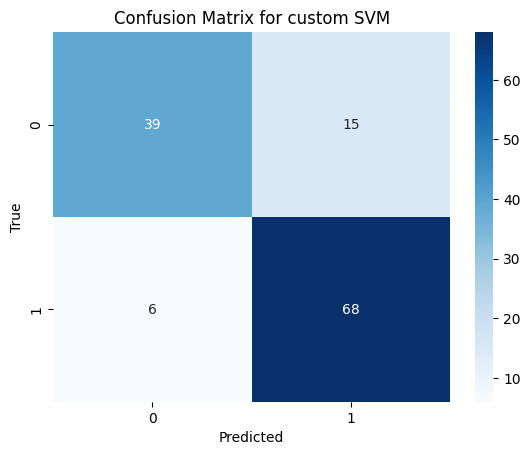

In [29]:
conf_matrix_custom_svm = confusion_matrix(y_test, y_pred_custom_svm)
sns.heatmap(conf_matrix_custom_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for custom SVM')
plt.show()

<h1>Logistic Regression in sklearn: </h1>

Accuracy with sklearn Logistic Regression: 84.38%


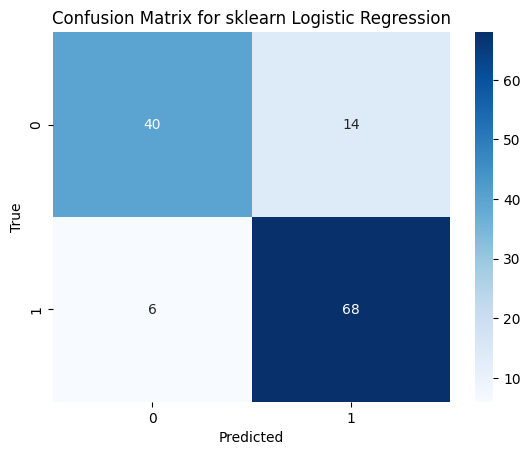

In [25]:
log_reg = LogisticRegression()
log_reg.fit(X_train_normalized, y_train)
y_pred_log_reg = log_reg.predict(X_test_normalized)

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f'Accuracy with sklearn Logistic Regression: {accuracy_log_reg * 100:.2f}%')

conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for sklearn Logistic Regression')
plt.show()

<h1>Logistic Regression from scratch:</h1>

In [26]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / self.m) * np.dot(X.T, (y_predicted - y))
            db = (1 / self.m) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_class = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_class)

custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X_train_normalized, y_train)
y_pred_custom_log_reg = custom_log_reg.predict(X_test_normalized)

accuracy_custom_log_reg = accuracy_score(y_test, y_pred_custom_log_reg)
print(f'Accuracy with custom Logistic Regression: {accuracy_custom_log_reg * 100:.2f}%')


Accuracy with custom Logistic Regression: 77.34%


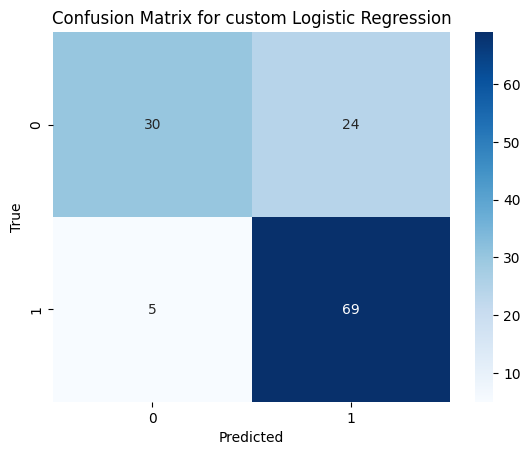

In [27]:
conf_matrix_custom_log_reg = confusion_matrix(y_test, y_pred_custom_log_reg)
sns.heatmap(conf_matrix_custom_log_reg, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for custom Logistic Regression')
plt.show()